### 1. Preprocess the data such as highly-variable gene filtering

See https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html for preprocessing

Use dandelion/dandelion/preprocessing/external/_preprocessing.py/recipe_scannpy_qc function to do preprocessing

<span style="color:yellow">**Attemp 1:**</span> filter multiple AnnData objects from dataset

In [1]:
# Environment set-up
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata
import scipy as scipy
import seaborn as sbn
import matplotlib.pyplot as plt
from dandelion.preprocessing.external._preprocessing import recipe_scanpy_qc

import warnings
warnings.filterwarnings("ignore")

In [6]:
from pathlib import Path

dataset_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE132509')

# Use a dictionary to store AnnData objects (Key: sample_name, Value: filtered_anndata)
adatas = {} 

for adata_path in dataset_directory.iterdir():
    if "_uni.h5ad" in adata_path.name:
        adata = anndata.read_h5ad(adata_path)
        adata.raw = adata
        print(adata_path.stem)

        # Do QC and filtering
        recipe_scanpy_qc(adata)
        adata = adata[adata.obs.filter_rna == 'False', :]

        # Do normalization
        sc.pp.normalize_total(adata)

        # Do the log transformation
        sc.pp.log1p(adata)

        # Select highky-variable genes
        sc.pp.highly_variable_genes(
            adata,
            flavor="seurat_v3",
            n_top_genes=2000,
            batch_key="dataset",
            subset=True,
        )

        adatas[adata_path.stem] = adata
        

GSM3872444_PBMMC_3_uni
GSM3872442_PBMMC_1_uni
GSM3872441_PRE-T_2_uni
GSM3872443_PBMMC_2_uni
GSM3872437_ETV6-RUNX1_4_uni
GSM3872438_HHD_1_uni
GSM3872439_HHD_2_uni
GSM3872435_ETV6-RUNX1_2_uni
GSM3872434_ETV6-RUNX1_1_uni
GSM3872440_PRE-T_1_uni
GSM3872436_ETV6-RUNX1_3_uni


In [12]:
# Obtain the anndata objs list
adatas_list = [adata for adata in adatas.values()]

[AnnData object with n_obs × n_vars = 1741 × 2000
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', AnnData object with n_obs × n_vars = 1242 × 2000
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', AnnData object with n_obs × n_vars = 1053 × 2000
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_c

### 2. Integration with Scanorama

See https://github.com/brianhie/scanorama for more info

In [15]:
import scanorama
corrected = scanorama.correct_scanpy(adatas_list, return_dimred=True)

Found 65 genes among all datasets
[[0.         0.80354267 0.11257898 0.54049397 0.25215393 0.24296381
  0.03733487 0.23090178 0.02354968 0.03848363 0.09615385]
 [0.         0.         0.05394525 0.50241546 0.22624799 0.46457327
  0.01127214 0.12318841 0.05877617 0.04267311 0.09017713]
 [0.         0.         0.         0.10636277 0.00664767 0.02849003
  0.03608737 0.0322887  0.01614435 0.51661918 0.02173913]
 [0.         0.         0.         0.         0.40425532 0.21045328
  0.01618871 0.08556892 0.03561517 0.03700278 0.16049954]
 [0.         0.         0.         0.         0.         0.29547553
  0.01390645 0.40264963 0.09069307 0.00663781 0.51421405]
 [0.         0.         0.         0.         0.         0.
  0.61862621 0.29239766 0.23730379 0.0378578  0.17558528]
 [0.         0.         0.         0.         0.         0.
  0.         0.2583228  0.08765276 0.00337126 0.0326087 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.69227723 0.015

In [17]:
corrected

[AnnData object with n_obs × n_vars = 1741 × 65
     obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna'
     var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
     uns: 'log1p', 'hvg'
     obsm: 'X_scanorama',
 AnnData object with n_obs × n_vars = 1242 × 65
     obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna'
     var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
     uns: 'log1p', 'hvg'
     obsm: 'X_scanorama',
 AnnData object with n_obs × n_vars = 1053 × 65
     obs: 'cancer_type', 'dataset', 'tissue', 'u

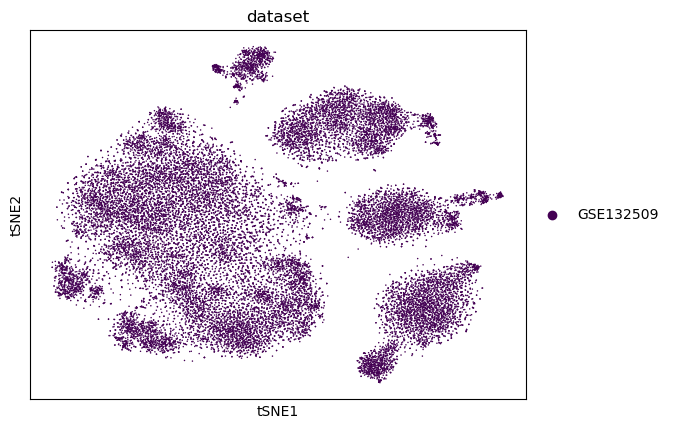

In [19]:
# Concatenate the integrated AnnData objects
adata_integrated = sc.AnnData.concatenate(*corrected)

# Run t-SNE on the integrated embeddings
sc.tl.tsne(adata_integrated, use_rep='X_scanorama')

# Visualize t-SNE embeddings
sc.pl.tsne(adata_integrated, color='dataset', palette='viridis')